## Data exploration and Analysis

This notebook explores the author data in the dataset in order to better understand the dataset statistics.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import umap

In [2]:
data_path = "data/processed_normalized_data.pkl"

data: pd.DataFrame = pd.read_pickle(data_path)
data.head()

,name,abstract,url,authors,conference,year,embedding
0,1000 fps hdr video with a spike-rgb hybrid camera,Capturing high frame rate and high dynamic ran...,https://cvpr.thecvf.com//virtual/2023/poster/2...,"[yakun chang, chu zhou, yuchen hong, liwen hu,...",cvpr,2023,"[0.06758018583059311, -0.010103985667228699, -..."
1,3davatargan: bridging domains for personalized...,Modern 3D-GANs synthesize geometry and texture...,https://cvpr.thecvf.com//virtual/2023/poster/2...,"[rameen abdal, hsin-ying lee, menglei chai, al...",cvpr,2023,"[-0.021240560337901115, -0.0026797682512551546..."
2,3d-aware conditional image synthesis,"We propose pix2pix3D, a 3D-aware conditional g...",https://cvpr.thecvf.com//virtual/2023/poster/2...,"[kangle deng, gengshan yang, deva ramanan, jun...",cvpr,2023,"[-0.03611314669251442, 0.06023111194372177, -0..."
3,3d-aware face swapping,Face swapping is an important research topic i...,https://cvpr.thecvf.com//virtual/2023/poster/2...,"[yixuan li, chao ma, yichao yan, wenhan zhu, x...",cvpr,2023,"[-0.03949457406997681, -0.0005436016945168376,..."
4,3d-aware facial landmark detection via multi-v...,Accurate facial landmark detection on wild ima...,https://cvpr.thecvf.com//virtual/2023/poster/2...,"[lele chen, wentao bao, zhong li, yi xu, junso...",cvpr,2023,"[-0.018743695691227913, 0.09058597683906555, -..."


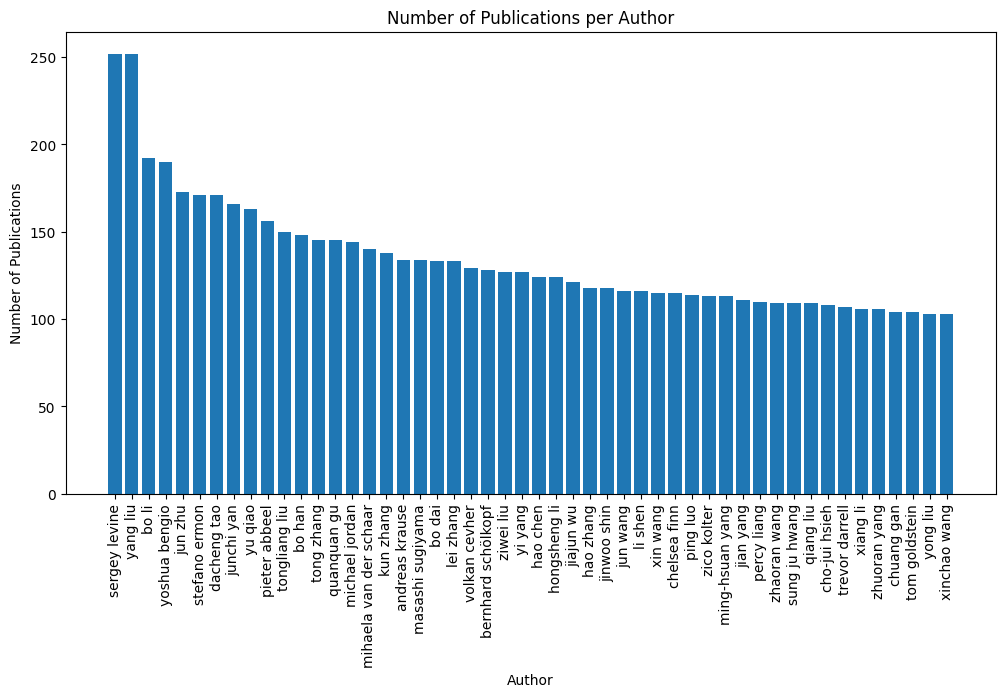

Number of unique authors: 28772


In [3]:
authors = data["authors"].to_list()

authors_flat = [author.strip().lower() for sublist in authors for author in sublist]
unique_authors, num_papers_per_author = np.unique(authors_flat, return_counts=True)

papers_per_author = {
    author: count for author, count in zip(unique_authors, num_papers_per_author)
}

# sort unique and counts by counts descending
sorted_indices = np.argsort(-num_papers_per_author)
unique_authors = unique_authors[sorted_indices]
num_papers_per_author = num_papers_per_author[sorted_indices]

plt.figure(figsize=(12, 6))
plt.bar(unique_authors[:50], num_papers_per_author[:50])
plt.xlabel("Author")
plt.ylabel("Number of Publications")
plt.title("Number of Publications per Author")
plt.xticks(rotation=90)
plt.show()

print("Number of unique authors:", len(unique_authors))

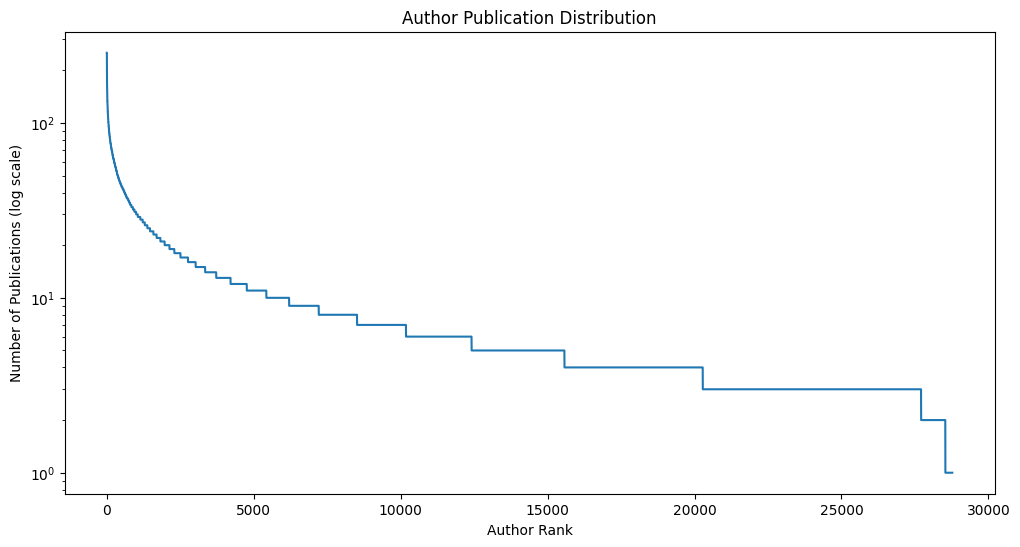

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(num_papers_per_author)
plt.yscale("log")
plt.xlabel("Author Rank")
plt.ylabel("Number of Publications (log scale)")
plt.title("Author Publication Distribution")
plt.show()

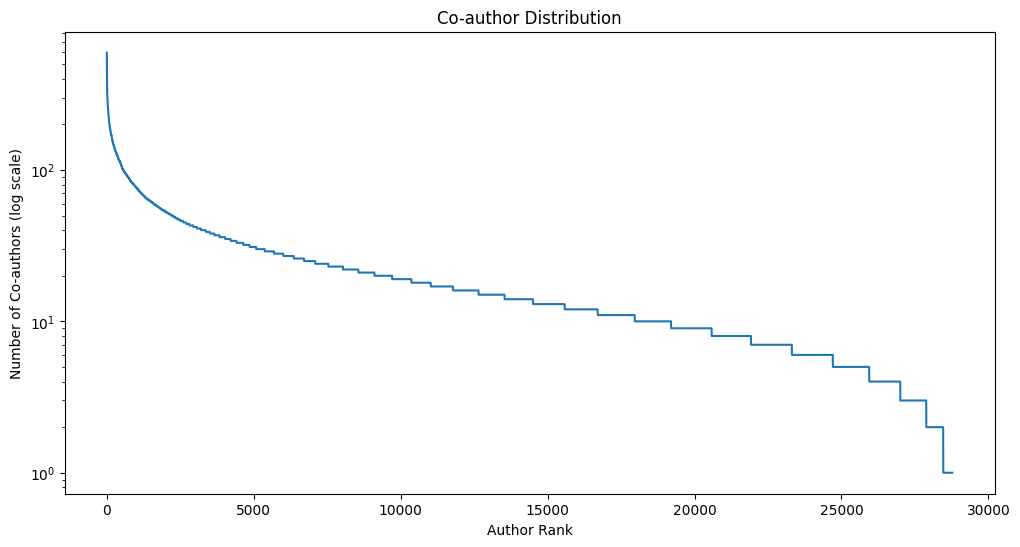

Author with most co-authors: yang liu with 595 co-authors
Top 10 authors with most co-authors:


In [5]:
coauthors_per_author = {str(author): set() for author in unique_authors}
for coauthor_list in authors:
    for author in coauthor_list:
        author_norm = author.strip().lower()
        coauthors = set(coauthor_list) - {author_norm}
        coauthors_per_author[author_norm].update(coauthors)
        
num_coauthors_per_author = {
    author: len(coauthors) for author, coauthors in coauthors_per_author.items()
}

num_coauthors = np.array(list(num_coauthors_per_author.values()))
num_coauthors_sorted = np.sort(num_coauthors)[::-1]
plt.figure(figsize=(12, 6))
plt.plot(num_coauthors_sorted)
plt.yscale("log")
plt.xlabel("Author Rank")
plt.ylabel("Number of Co-authors (log scale)")
plt.title("Co-author Distribution")
plt.show()

# author with the most coauthors
top_author = unique_authors[np.argmax(num_coauthors)]
print(f"Author with most co-authors: {top_author} with {num_coauthors_per_author[top_author]} co-authors")

sorted_unique_authors_coauthors = sorted(
    num_coauthors_per_author.items(), key=lambda x: x[1], reverse=True
)
print("Top 10 authors with most co-authors:")
with open("top_authors_coauthors.txt", "w") as f:
    for author, count in sorted_unique_authors_coauthors:
        f.write(f"{author}: {count}\n")
        


In [6]:
# get the clusters of the 10 most prolific authors
top_authors = unique_authors[:10]
top_author_indices = {author: [] for author in top_authors}
for i, coauthor_list in enumerate(authors):
    coauthor_list_norm = [author.strip().lower() for author in coauthor_list]
    for author in top_authors:
        if author in coauthor_list_norm:
            top_author_indices[author].append(i)

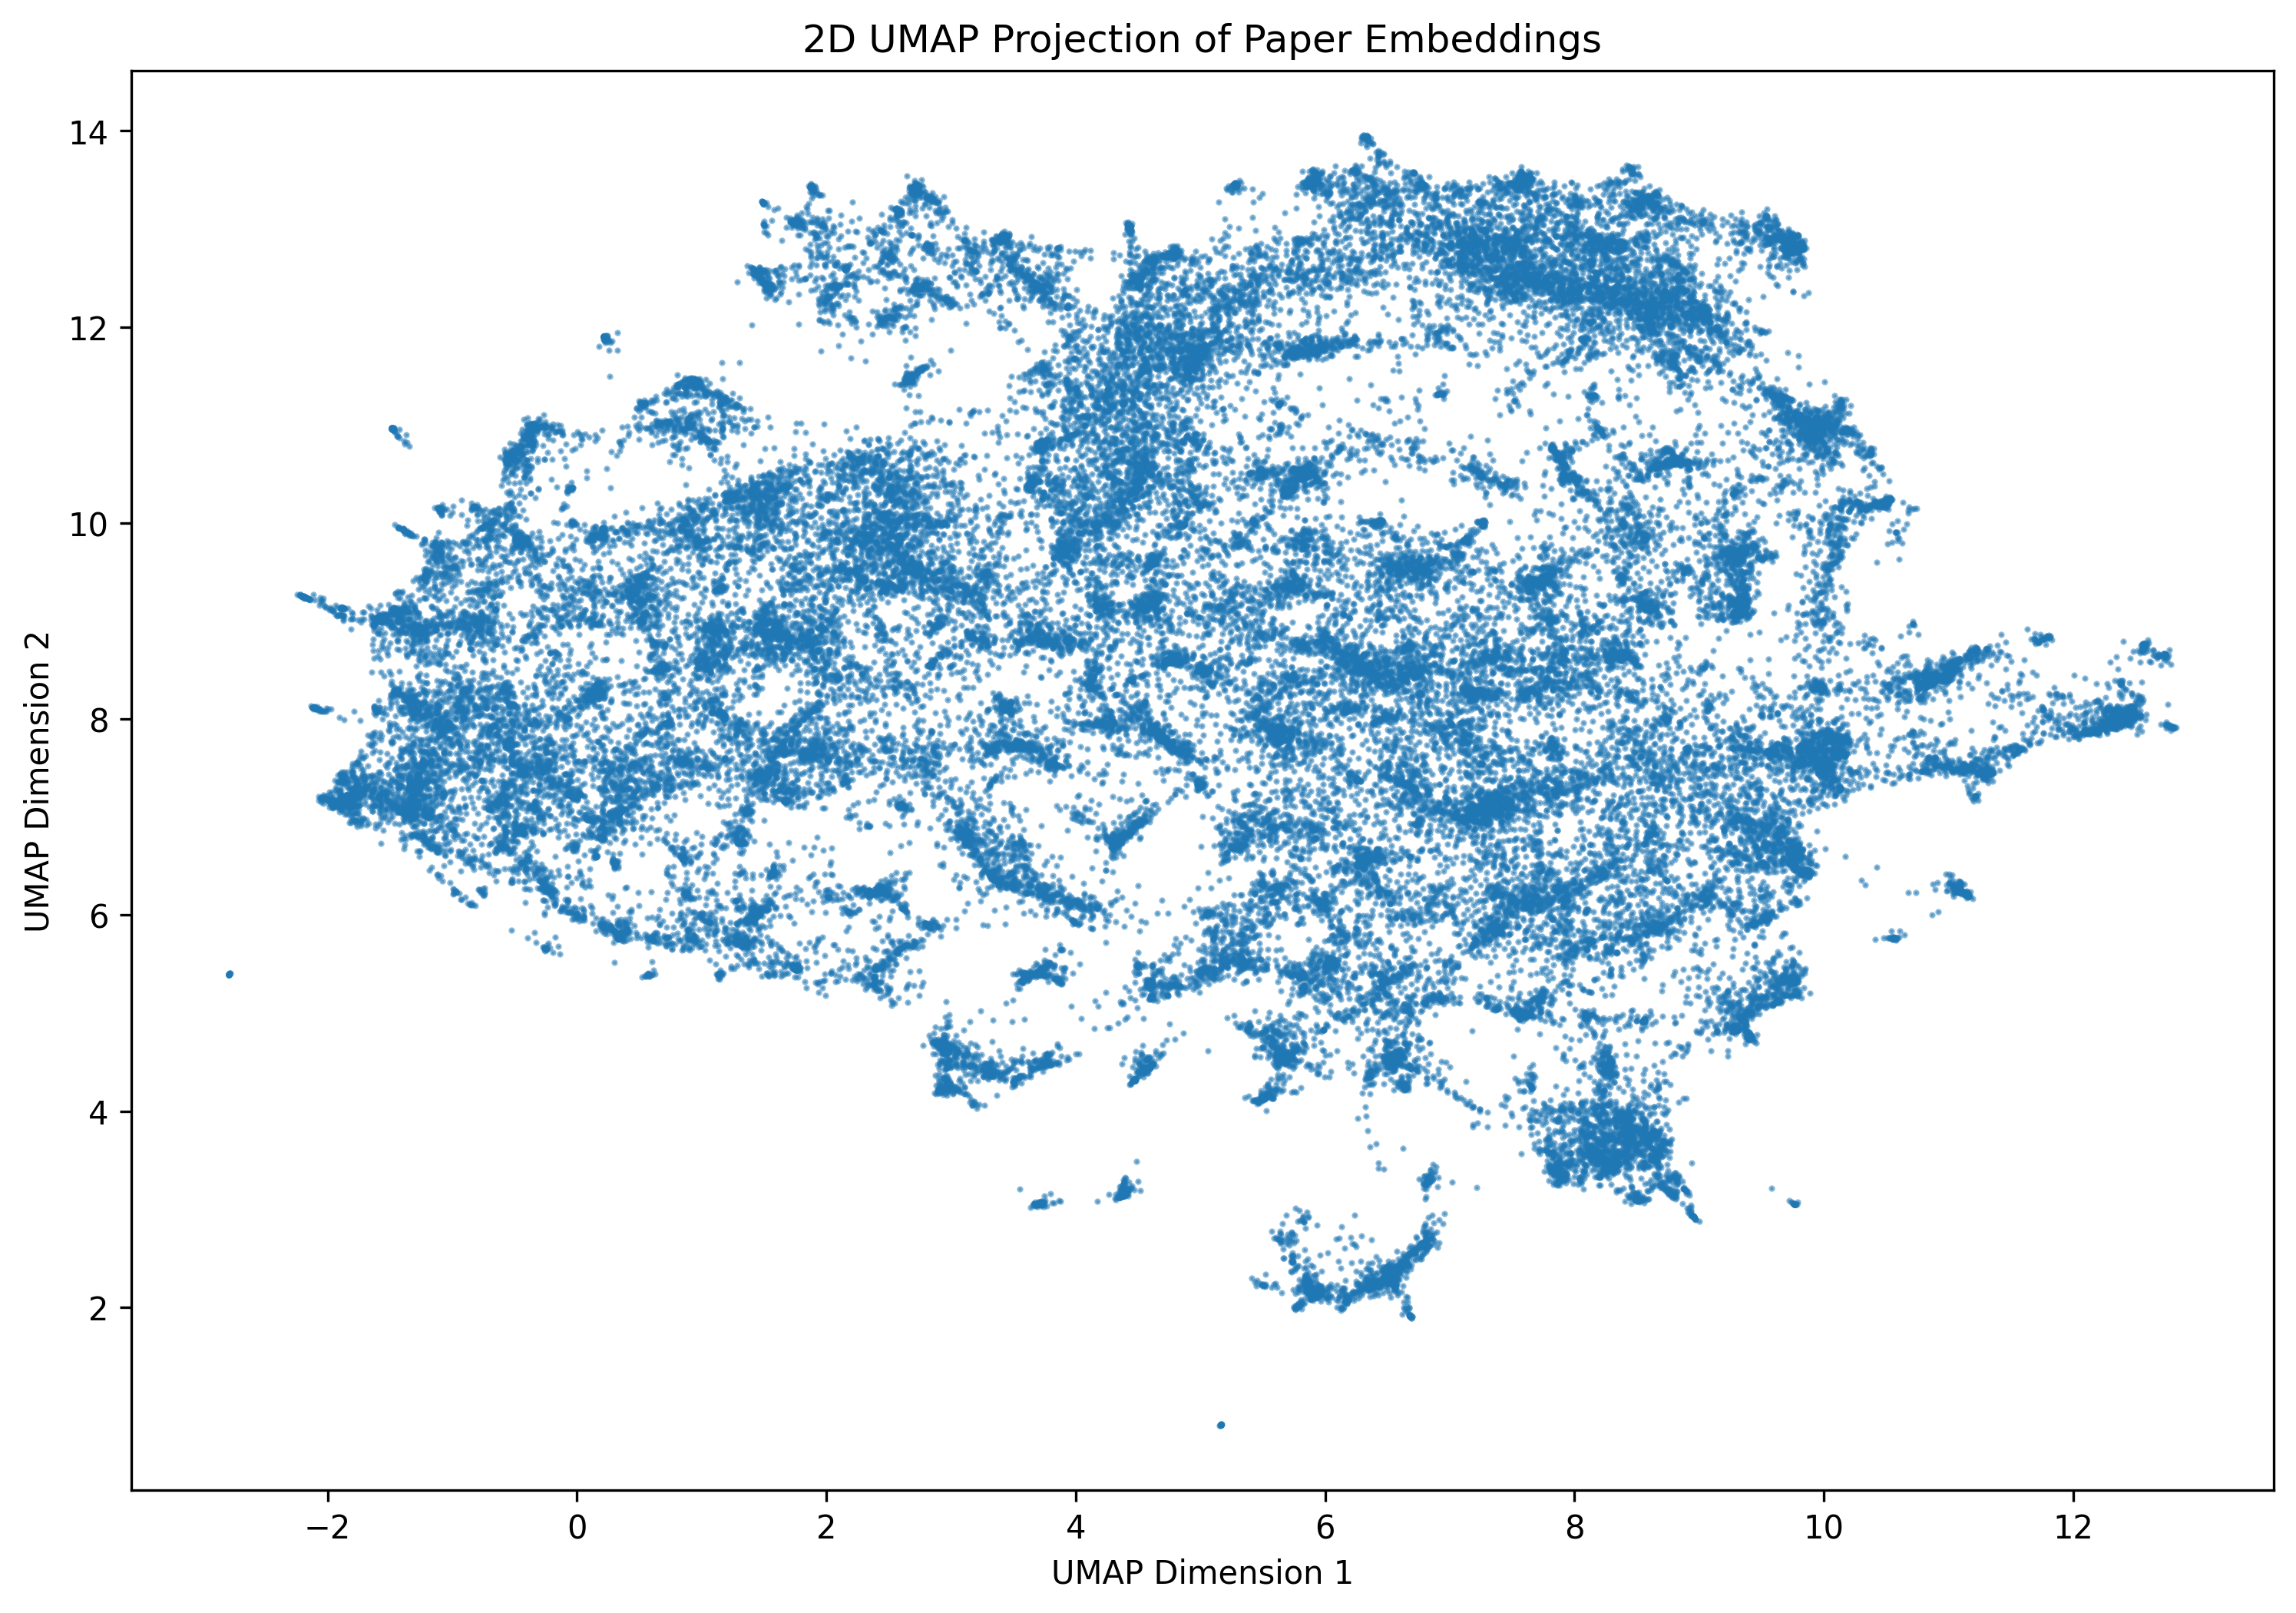

In [7]:
conferences = data["conference"].to_list()
embeddings = data["embedding"].to_list()
embeddings = np.array(embeddings, dtype=np.float32)
umap_reducer = umap.UMAP(n_components=2)
embeddings_2d = umap_reducer.fit_transform(embeddings)

plt.figure(figsize=(12, 8), dpi=300)
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=1, alpha=0.5)
plt.title("2D UMAP Projection of Paper Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

In [8]:
# Get the number of edges in the Graph
# Edge Types:
# - Autor to Author (Coauthor edges)
# - Author to Paper (Authorship edges)

num_coauthor_edges = 0
for coauthor_list in authors:
    # each paper comes with a clique of authors
    n = len(coauthor_list)
    num_coauthor_edges += n * (n - 1) // 2  # number of edges in a complete graph of n nodes
    
# Each paper introduces one edge from each author to the paper
num_authorship_edges = sum(len(coauthor_list) for coauthor_list in authors)

# Nodes are authors and papers
# Node Types:
# - Author Nodes
# - Paper Nodes

num_author_nodes = len(unique_authors)
num_paper_nodes = len(data)

print(f"Total number of Coauthor edges: {num_coauthor_edges}")
print(f"Total number of Authorship edges: {num_authorship_edges}")
print(f"Total number of edges in the graph: {num_coauthor_edges + num_authorship_edges}")
print("-------------------------------")
print(f"Total number of Author nodes: {num_author_nodes}")
print(f"Total number of Paper nodes: {num_paper_nodes}")
print(f"Total number of nodes in the graph: {num_author_nodes + num_paper_nodes}")

Total number of Coauthor edges: 506076
Total number of Authorship edges: 236503
Total number of edges in the graph: 742579
-------------------------------
Total number of Author nodes: 28772
Total number of Paper nodes: 56063
Total number of nodes in the graph: 84835
